In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/3))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 32)          10272     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 32)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1920 - acc: 0.2929
Epoch 00001: val_loss improved from inf to 1.67022, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_4_conv_checkpoint/001-1.6702.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.1919 - acc: 0.2929 - val_loss: 1.6702 - val_acc: 0.4631
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6194 - acc: 0.4785
Epoch 00002: val_loss improved from 1.67022 to 1.51259, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_4_conv_checkpoint/002-1.5126.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.6194 - acc: 0.4785 - val_loss: 1.5126 - val_acc: 0.5174
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4378 - acc: 0.5492
Epoch 00003: val_loss improved from 1.51259 to 1.36347, saving mode

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4243 - acc: 0.8647
Epoch 00025: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4244 - acc: 0.8647 - val_loss: 0.9917 - val_acc: 0.7321
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4187 - acc: 0.8653
Epoch 00026: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4187 - acc: 0.8653 - val_loss: 0.9939 - val_acc: 0.7242
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4027 - acc: 0.8698
Epoch 00027: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4027 - acc: 0.8698 - val_loss: 1.0240 - val_acc: 0.7198
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3842 - acc: 0.8752
Epoch 00028: val_loss did not improve from 0.97372
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2234 - acc: 0.9256
Epoch 00055: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2234 - acc: 0.9256 - val_loss: 1.0548 - val_acc: 0.7556
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2208 - acc: 0.9272
Epoch 00056: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2208 - acc: 0.9272 - val_loss: 1.0699 - val_acc: 0.7556
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2162 - acc: 0.9284
Epoch 00057: val_loss did not improve from 0.97372
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2161 - acc: 0.9284 - val_loss: 1.1000 - val_acc: 0.7466
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2082 - acc: 0.9327
Epoch 00058: val_loss did not improve from 0.97372
36805/36805 [===========

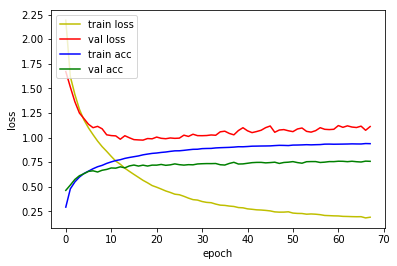

4815/4815 [==============================] - 3s 562us/sample - loss: 1.0616 - acc: 0.6816
Loss: 1.0616259873594203 Accuracy: 0.68161994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3388 - acc: 0.2279
Epoch 00001: val_loss improved from inf to 1.82587, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_5_conv_checkpoint/001-1.8259.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.3388 - acc: 0.2279 - val_loss: 1.8259 - val_acc: 0.4135
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7483 - acc: 0.4254
Epoch 00002: val_loss improved from 1.82587 to 1.50217, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_5_conv_checkpoint/002-1.5022.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.7483 - acc: 0.4254 - val_loss: 1.5022 - val_acc: 0.5283
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.6576 - acc: 0.8010
Epoch 00023: val_loss did not improve from 0.71282
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6576 - acc: 0.8010 - val_loss: 0.7340 - val_acc: 0.7927
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6376 - acc: 0.8077
Epoch 00024: val_loss improved from 0.71282 to 0.71122, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_5_conv_checkpoint/024-0.7112.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.6376 - acc: 0.8078 - val_loss: 0.7112 - val_acc: 0.7918
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6216 - acc: 0.8118
Epoch 00025: val_loss did not improve from 0.71122
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.6216 - acc: 0.8118 - val_loss: 0.7124 - val_acc: 0.7920
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6093 - acc

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4208 - acc: 0.8681
Epoch 00050: val_loss did not improve from 0.65037
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4209 - acc: 0.8681 - val_loss: 0.6714 - val_acc: 0.8176
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4153 - acc: 0.8690
Epoch 00051: val_loss did not improve from 0.65037
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4152 - acc: 0.8690 - val_loss: 0.6623 - val_acc: 0.8192
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4097 - acc: 0.8707
Epoch 00052: val_loss did not improve from 0.65037
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4096 - acc: 0.8707 - val_loss: 0.6516 - val_acc: 0.8223
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4054 - acc: 0.8710
Epoch 00053: val_loss did not improve from 0.65037
36805/36805 [===========

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3163 - acc: 0.8960
Epoch 00079: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3165 - acc: 0.8960 - val_loss: 0.6672 - val_acc: 0.8316
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3192 - acc: 0.8953
Epoch 00080: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3192 - acc: 0.8953 - val_loss: 0.6722 - val_acc: 0.8309
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3203 - acc: 0.8958
Epoch 00081: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3207 - acc: 0.8957 - val_loss: 0.6797 - val_acc: 0.8232
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3194 - acc: 0.8965
Epoch 00082: val_loss did not improve from 0.64714
36805/36805 [===========

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.9111
Epoch 00109: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2671 - acc: 0.9110 - val_loss: 0.6880 - val_acc: 0.8344
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9129
Epoch 00110: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2700 - acc: 0.9129 - val_loss: 0.7004 - val_acc: 0.8279
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2654 - acc: 0.9132
Epoch 00111: val_loss did not improve from 0.64714
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2653 - acc: 0.9132 - val_loss: 0.7003 - val_acc: 0.8281
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2553 - acc: 0.9160
Epoch 00112: val_loss did not improve from 0.64714
36805/36805 [=======

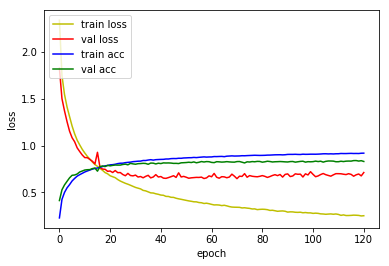

4815/4815 [==============================] - 3s 590us/sample - loss: 0.7404 - acc: 0.8019
Loss: 0.740428773425945 Accuracy: 0.80186915

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5216 - acc: 0.1753
Epoch 00001: val_loss improved from inf to 2.00508, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/001-2.0051.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.5215 - acc: 0.1754 - val_loss: 2.0051 - val_acc: 0.3701
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9047 - acc: 0.3735
Epoch 00002: val_loss improved from 2.00508 to 1.60065, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/002-1.6006.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.9047 - acc: 0.3736 - val_loss: 1.6006 - val_acc: 0.5015
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.6906 - acc: 0.7905
Epoch 00023: val_loss improved from 0.60890 to 0.60769, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/023-0.6077.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6910 - acc: 0.7905 - val_loss: 0.6077 - val_acc: 0.8295
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6714 - acc: 0.7984
Epoch 00024: val_loss improved from 0.60769 to 0.58529, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/024-0.5853.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6714 - acc: 0.7984 - val_loss: 0.5853 - val_acc: 0.8351
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6607 - acc: 0.8005
Epoch 00025: val_loss improved from 0.58529 to 0.56947, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/025-0.5695.hdf5
36805/36805 [=========

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4589 - acc: 0.8600
Epoch 00048: val_loss improved from 0.44068 to 0.43904, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/048-0.4390.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4589 - acc: 0.8600 - val_loss: 0.4390 - val_acc: 0.8814
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4566 - acc: 0.8619
Epoch 00049: val_loss did not improve from 0.43904
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4566 - acc: 0.8619 - val_loss: 0.4528 - val_acc: 0.8793
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4520 - acc: 0.8621
Epoch 00050: val_loss did not improve from 0.43904
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4520 - acc: 0.8622 - val_loss: 0.4473 - val_acc: 0.8749
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3587 - acc: 0.8896
Epoch 00075: val_loss improved from 0.38187 to 0.38159, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/075-0.3816.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3588 - acc: 0.8895 - val_loss: 0.3816 - val_acc: 0.8989
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3621 - acc: 0.8877
Epoch 00076: val_loss did not improve from 0.38159
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3621 - acc: 0.8877 - val_loss: 0.3964 - val_acc: 0.8968
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3587 - acc: 0.8895
Epoch 00077: val_loss did not improve from 0.38159
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3587 - acc: 0.8895 - val_loss: 0.4028 - val_acc: 0.8954
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.3057 - acc: 0.9025
Epoch 00102: val_loss did not improve from 0.36216
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3057 - acc: 0.9025 - val_loss: 0.3749 - val_acc: 0.9033
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3065 - acc: 0.9035
Epoch 00103: val_loss did not improve from 0.36216
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3065 - acc: 0.9035 - val_loss: 0.3685 - val_acc: 0.9047
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3066 - acc: 0.9025
Epoch 00104: val_loss improved from 0.36216 to 0.35792, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_6_conv_checkpoint/104-0.3579.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3066 - acc: 0.9025 - val_loss: 0.3579 - val_acc: 0.9057
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3113 - 

Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2751 - acc: 0.9124
Epoch 00131: val_loss did not improve from 0.34970
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2751 - acc: 0.9124 - val_loss: 0.3668 - val_acc: 0.9115
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2704 - acc: 0.9134
Epoch 00132: val_loss did not improve from 0.34970
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2705 - acc: 0.9134 - val_loss: 0.3576 - val_acc: 0.9096
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2719 - acc: 0.9138
Epoch 00133: val_loss did not improve from 0.34970
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2721 - acc: 0.9138 - val_loss: 0.3624 - val_acc: 0.9082
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2690 - acc: 0.9144
Epoch 00134: val_loss did not improve from 0.34970
36805/36805 [=======

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2469 - acc: 0.9192
Epoch 00160: val_loss did not improve from 0.34235
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2469 - acc: 0.9191 - val_loss: 0.3515 - val_acc: 0.9108
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2369 - acc: 0.9237
Epoch 00161: val_loss did not improve from 0.34235
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2369 - acc: 0.9237 - val_loss: 0.3562 - val_acc: 0.9117
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2399 - acc: 0.9221
Epoch 00162: val_loss did not improve from 0.34235
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2400 - acc: 0.9220 - val_loss: 0.3577 - val_acc: 0.9159
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2404 - acc: 0.9203
Epoch 00163: val_loss did not improve from 0.34235
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2227 - acc: 0.9277
Epoch 00189: val_loss did not improve from 0.34111
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2227 - acc: 0.9277 - val_loss: 0.3588 - val_acc: 0.9143
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2194 - acc: 0.9281
Epoch 00190: val_loss did not improve from 0.34111
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2194 - acc: 0.9281 - val_loss: 0.3765 - val_acc: 0.9126
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9287
Epoch 00191: val_loss did not improve from 0.34111
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2198 - acc: 0.9287 - val_loss: 0.3516 - val_acc: 0.9157
Epoch 192/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9275
Epoch 00192: val_loss did not improve from 0.34111
36805/36805 [=====================

Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2004 - acc: 0.9339
Epoch 00218: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2004 - acc: 0.9339 - val_loss: 0.3858 - val_acc: 0.9152
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9346
Epoch 00219: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2028 - acc: 0.9346 - val_loss: 0.3715 - val_acc: 0.9129
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1989 - acc: 0.9342
Epoch 00220: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1989 - acc: 0.9342 - val_loss: 0.3541 - val_acc: 0.9175
Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2003 - acc: 0.9330
Epoch 00221: val_loss did not improve from 0.33577
36805/36805 [=======

Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1879 - acc: 0.9379
Epoch 00248: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1878 - acc: 0.9379 - val_loss: 0.3622 - val_acc: 0.9201
Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1849 - acc: 0.9385
Epoch 00249: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1850 - acc: 0.9385 - val_loss: 0.3496 - val_acc: 0.9192
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1898 - acc: 0.9363
Epoch 00250: val_loss did not improve from 0.33577
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1898 - acc: 0.9363 - val_loss: 0.3416 - val_acc: 0.9201
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1834 - acc: 0.9389
Epoch 00251: val_loss did not improve from 0.33577
36805/36805 [=======

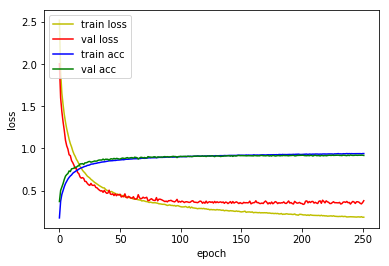

4815/4815 [==============================] - 3s 602us/sample - loss: 0.4032 - acc: 0.8933
Loss: 0.40324922873099894 Accuracy: 0.8932503

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6266 - acc: 0.1268
Epoch 00001: val_loss improved from inf to 2.26001, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/001-2.2600.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 2.6265 - acc: 0.1269 - val_loss: 2.2600 - val_acc: 0.2758
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2006 - acc: 0.2656
Epoch 00002: val_loss improved from 2.26001 to 1.85434, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/002-1.8543.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.2006 - acc: 0.2656 - val_loss: 1.8543 - val_acc: 0.4239
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.9033 - acc: 0.7210
Epoch 00023: val_loss did not improve from 0.72217
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.9033 - acc: 0.7210 - val_loss: 0.7251 - val_acc: 0.7952
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8883 - acc: 0.7254
Epoch 00024: val_loss improved from 0.72217 to 0.65273, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/024-0.6527.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.8883 - acc: 0.7254 - val_loss: 0.6527 - val_acc: 0.8088
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8716 - acc: 0.7319
Epoch 00025: val_loss did not improve from 0.65273
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.8716 - acc: 0.7319 - val_loss: 0.6565 - val_acc: 0.8120
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8443 - acc

36800/36805 [============================>.] - ETA: 0s - loss: 0.6331 - acc: 0.8087
Epoch 00048: val_loss did not improve from 0.42838
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6335 - acc: 0.8087 - val_loss: 0.4663 - val_acc: 0.8682
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6332 - acc: 0.8086
Epoch 00049: val_loss did not improve from 0.42838
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6332 - acc: 0.8086 - val_loss: 0.4443 - val_acc: 0.8707
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6205 - acc: 0.8091
Epoch 00050: val_loss did not improve from 0.42838
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.6204 - acc: 0.8091 - val_loss: 0.4297 - val_acc: 0.8768
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6244 - acc: 0.8102
Epoch 00051: val_loss did not improve from 0.42838
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5259 - acc: 0.8391
Epoch 00074: val_loss improved from 0.34763 to 0.34555, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/074-0.3456.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5259 - acc: 0.8391 - val_loss: 0.3456 - val_acc: 0.8984
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5272 - acc: 0.8389
Epoch 00075: val_loss did not improve from 0.34555
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5271 - acc: 0.8390 - val_loss: 0.3482 - val_acc: 0.9008
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5204 - acc: 0.8401
Epoch 00076: val_loss did not improve from 0.34555
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5203 - acc: 0.8401 - val_loss: 0.3480 - val_acc: 0.9066
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5138 - acc

Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4580 - acc: 0.8576
Epoch 00101: val_loss did not improve from 0.30243
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4580 - acc: 0.8576 - val_loss: 0.3372 - val_acc: 0.9050
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4585 - acc: 0.8588
Epoch 00102: val_loss did not improve from 0.30243
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4585 - acc: 0.8589 - val_loss: 0.3090 - val_acc: 0.9115
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4508 - acc: 0.8611
Epoch 00103: val_loss did not improve from 0.30243
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4508 - acc: 0.8612 - val_loss: 0.3127 - val_acc: 0.9171
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4561 - acc: 0.8594
Epoch 00104: val_loss did not improve from 0.30243
36805/36805 [=======

Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4136 - acc: 0.8718
Epoch 00128: val_loss improved from 0.27257 to 0.27075, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/128-0.2707.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4136 - acc: 0.8718 - val_loss: 0.2707 - val_acc: 0.9250
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4130 - acc: 0.8707
Epoch 00129: val_loss did not improve from 0.27075
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4130 - acc: 0.8707 - val_loss: 0.2823 - val_acc: 0.9217
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4051 - acc: 0.8729
Epoch 00130: val_loss did not improve from 0.27075
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4052 - acc: 0.8729 - val_loss: 0.2799 - val_acc: 0.9241
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.8819
Epoch 00156: val_loss did not improve from 0.26088
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3746 - acc: 0.8819 - val_loss: 0.2620 - val_acc: 0.9311
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3675 - acc: 0.8836
Epoch 00157: val_loss did not improve from 0.26088
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3674 - acc: 0.8836 - val_loss: 0.2625 - val_acc: 0.9320
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3655 - acc: 0.8854
Epoch 00158: val_loss did not improve from 0.26088
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3654 - acc: 0.8854 - val_loss: 0.2650 - val_acc: 0.9294
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3728 - acc: 0.8842
Epoch 00159: val_loss did not improve from 0.26088
36805/36805 [=====================

Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3379 - acc: 0.8949
Epoch 00184: val_loss did not improve from 0.25223
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3379 - acc: 0.8949 - val_loss: 0.2737 - val_acc: 0.9283
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3434 - acc: 0.8914
Epoch 00185: val_loss improved from 0.25223 to 0.25197, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/185-0.2520.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3434 - acc: 0.8914 - val_loss: 0.2520 - val_acc: 0.9359
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3392 - acc: 0.8943
Epoch 00186: val_loss improved from 0.25197 to 0.24838, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_7_conv_checkpoint/186-0.2484.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3394 - acc: 0.8943 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3116 - acc: 0.8994
Epoch 00212: val_loss did not improve from 0.24288
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3117 - acc: 0.8994 - val_loss: 0.2532 - val_acc: 0.9355
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3136 - acc: 0.9004
Epoch 00213: val_loss did not improve from 0.24288
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3136 - acc: 0.9004 - val_loss: 0.2492 - val_acc: 0.9343
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3208 - acc: 0.8990
Epoch 00214: val_loss did not improve from 0.24288
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3208 - acc: 0.8991 - val_loss: 0.2476 - val_acc: 0.9373
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3110 - acc: 0.9004
Epoch 00215: val_loss did not improve from 0.24288
36805/36805 [=====================

Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2887 - acc: 0.9060
Epoch 00241: val_loss did not improve from 0.23668
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2888 - acc: 0.9060 - val_loss: 0.2537 - val_acc: 0.9373
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3006 - acc: 0.9030
Epoch 00242: val_loss did not improve from 0.23668
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3006 - acc: 0.9029 - val_loss: 0.2482 - val_acc: 0.9380
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2932 - acc: 0.9068
Epoch 00243: val_loss did not improve from 0.23668
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2932 - acc: 0.9069 - val_loss: 0.2511 - val_acc: 0.9425
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2933 - acc: 0.9067
Epoch 00244: val_loss did not improve from 0.23668
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.9108
Epoch 00270: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2766 - acc: 0.9108 - val_loss: 0.2379 - val_acc: 0.9408
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2767 - acc: 0.9113
Epoch 00271: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2767 - acc: 0.9113 - val_loss: 0.2393 - val_acc: 0.9371
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2709 - acc: 0.9117
Epoch 00272: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2709 - acc: 0.9117 - val_loss: 0.2492 - val_acc: 0.9359
Epoch 273/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.9108
Epoch 00273: val_loss did not improve from 0.22990
36805/36805 [=====================

Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2612 - acc: 0.9144
Epoch 00300: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2613 - acc: 0.9144 - val_loss: 0.2404 - val_acc: 0.9385
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.9153
Epoch 00301: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2584 - acc: 0.9153 - val_loss: 0.2381 - val_acc: 0.9408
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.9168
Epoch 00302: val_loss did not improve from 0.22990
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2604 - acc: 0.9169 - val_loss: 0.2343 - val_acc: 0.9394
Epoch 303/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2591 - acc: 0.9160
Epoch 00303: val_loss did not improve from 0.22990
36805/36805 [=======

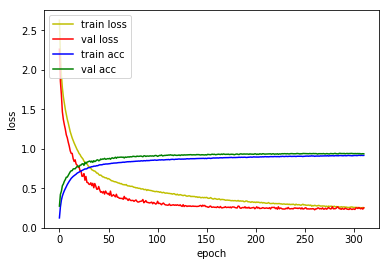

4815/4815 [==============================] - 3s 570us/sample - loss: 0.2918 - acc: 0.9190
Loss: 0.291794709649289 Accuracy: 0.9190031

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7390 - acc: 0.0857
Epoch 00001: val_loss improved from inf to 2.67261, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/001-2.6726.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.7391 - acc: 0.0856 - val_loss: 2.6726 - val_acc: 0.1491
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5541 - acc: 0.1746
Epoch 00002: val_loss improved from 2.67261 to 2.19912, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/002-2.1991.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.5539 - acc: 0.1747 - val_loss: 2.1991 - val_acc: 0.3359
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0018 - acc: 0.6811
Epoch 00023: val_loss improved from 0.70955 to 0.70449, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/023-0.7045.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.0019 - acc: 0.6810 - val_loss: 0.7045 - val_acc: 0.8074
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9989 - acc: 0.6811
Epoch 00024: val_loss did not improve from 0.70449
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.9989 - acc: 0.6810 - val_loss: 0.7117 - val_acc: 0.8027
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9790 - acc: 0.6908
Epoch 00025: val_loss improved from 0.70449 to 0.67095, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/025-0.6710.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.9791 - acc: 0.6908 - val_loss: 0.6

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7329 - acc: 0.7736
Epoch 00047: val_loss did not improve from 0.46473
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7328 - acc: 0.7736 - val_loss: 0.4938 - val_acc: 0.8591
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7253 - acc: 0.7745
Epoch 00048: val_loss improved from 0.46473 to 0.45052, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/048-0.4505.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7253 - acc: 0.7745 - val_loss: 0.4505 - val_acc: 0.8805
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7201 - acc: 0.7749
Epoch 00049: val_loss did not improve from 0.45052
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7201 - acc: 0.7749 - val_loss: 0.4630 - val_acc: 0.8735
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5931 - acc: 0.8152
Epoch 00073: val_loss improved from 0.35333 to 0.34499, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/073-0.3450.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5931 - acc: 0.8152 - val_loss: 0.3450 - val_acc: 0.9066
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5909 - acc: 0.8189
Epoch 00074: val_loss did not improve from 0.34499
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5909 - acc: 0.8190 - val_loss: 0.3490 - val_acc: 0.9026
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5863 - acc: 0.8177
Epoch 00075: val_loss did not improve from 0.34499
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5863 - acc: 0.8177 - val_loss: 0.3514 - val_acc: 0.8989
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.5037 - acc: 0.8438
Epoch 00098: val_loss improved from 0.29060 to 0.28761, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/098-0.2876.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5037 - acc: 0.8437 - val_loss: 0.2876 - val_acc: 0.9194
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4935 - acc: 0.8445
Epoch 00099: val_loss did not improve from 0.28761
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4936 - acc: 0.8445 - val_loss: 0.2981 - val_acc: 0.9173
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4934 - acc: 0.8464
Epoch 00100: val_loss did not improve from 0.28761
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.4934 - acc: 0.8464 - val_loss: 0.2885 - val_acc: 0.9161
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4893 - a

Epoch 125/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4350 - acc: 0.8629
Epoch 00125: val_loss did not improve from 0.26325
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4352 - acc: 0.8629 - val_loss: 0.2778 - val_acc: 0.9227
Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4350 - acc: 0.8644
Epoch 00126: val_loss did not improve from 0.26325
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4350 - acc: 0.8644 - val_loss: 0.2638 - val_acc: 0.9276
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4343 - acc: 0.8630
Epoch 00127: val_loss improved from 0.26325 to 0.26288, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/127-0.2629.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4343 - acc: 0.8630 - val_loss: 0.2629 - val_acc: 0.9269
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 152/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3909 - acc: 0.8769
Epoch 00152: val_loss did not improve from 0.24317
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3908 - acc: 0.8769 - val_loss: 0.2688 - val_acc: 0.9245
Epoch 153/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3918 - acc: 0.8768
Epoch 00153: val_loss did not improve from 0.24317
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3918 - acc: 0.8768 - val_loss: 0.2489 - val_acc: 0.9324
Epoch 154/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3904 - acc: 0.8773
Epoch 00154: val_loss did not improve from 0.24317
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3907 - acc: 0.8773 - val_loss: 0.2553 - val_acc: 0.9308
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3863 - acc: 0.8783
Epoch 00155: val_loss did not improve from 0.24317
36805/36805 [=======

Epoch 181/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3513 - acc: 0.8898
Epoch 00181: val_loss did not improve from 0.23377
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3513 - acc: 0.8898 - val_loss: 0.2356 - val_acc: 0.9355
Epoch 182/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3545 - acc: 0.8873
Epoch 00182: val_loss did not improve from 0.23377
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3544 - acc: 0.8873 - val_loss: 0.2552 - val_acc: 0.9297
Epoch 183/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3482 - acc: 0.8897
Epoch 00183: val_loss did not improve from 0.23377
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3482 - acc: 0.8897 - val_loss: 0.2444 - val_acc: 0.9343
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3459 - acc: 0.8896
Epoch 00184: val_loss did not improve from 0.23377
36805/36805 [=======

Epoch 210/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3208 - acc: 0.8962
Epoch 00210: val_loss did not improve from 0.22915
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3209 - acc: 0.8962 - val_loss: 0.2452 - val_acc: 0.9352
Epoch 211/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.8966
Epoch 00211: val_loss did not improve from 0.22915
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3228 - acc: 0.8966 - val_loss: 0.2426 - val_acc: 0.9343
Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3231 - acc: 0.8944
Epoch 00212: val_loss did not improve from 0.22915
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.3231 - acc: 0.8944 - val_loss: 0.2401 - val_acc: 0.9366
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3148 - acc: 0.8994
Epoch 00213: val_loss did not improve from 0.22915
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2915 - acc: 0.9064
Epoch 00239: val_loss did not improve from 0.22767
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2915 - acc: 0.9064 - val_loss: 0.2364 - val_acc: 0.9385
Epoch 240/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2976 - acc: 0.9017
Epoch 00240: val_loss did not improve from 0.22767
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2976 - acc: 0.9017 - val_loss: 0.2482 - val_acc: 0.9362
Epoch 241/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2926 - acc: 0.9047
Epoch 00241: val_loss did not improve from 0.22767
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2927 - acc: 0.9047 - val_loss: 0.2358 - val_acc: 0.9399
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3002 - acc: 0.9026
Epoch 00242: val_loss did not improve from 0.22767
36805/36805 [=====================

Epoch 269/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2772 - acc: 0.9107
Epoch 00269: val_loss improved from 0.22767 to 0.22550, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_8_conv_checkpoint/269-0.2255.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2771 - acc: 0.9107 - val_loss: 0.2255 - val_acc: 0.9380
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2760 - acc: 0.9098
Epoch 00270: val_loss did not improve from 0.22550
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2762 - acc: 0.9098 - val_loss: 0.2531 - val_acc: 0.9359
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2714 - acc: 0.9108
Epoch 00271: val_loss did not improve from 0.22550
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2714 - acc: 0.9108 - val_loss: 0.2430 - val_acc: 0.9357
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.2525 - acc: 0.9164
Epoch 00298: val_loss did not improve from 0.22550
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2525 - acc: 0.9164 - val_loss: 0.2504 - val_acc: 0.9387
Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2545 - acc: 0.9154
Epoch 00299: val_loss did not improve from 0.22550
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2545 - acc: 0.9154 - val_loss: 0.2501 - val_acc: 0.9380
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2537 - acc: 0.9172
Epoch 00300: val_loss did not improve from 0.22550
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2536 - acc: 0.9172 - val_loss: 0.2464 - val_acc: 0.9364
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2545 - acc: 0.9163
Epoch 00301: val_loss did not improve from 0.22550
36805/36805 [=====================

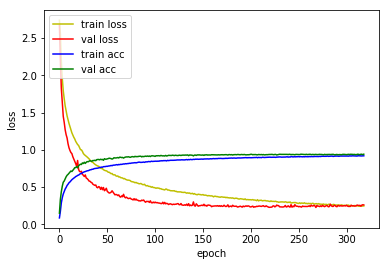

4815/4815 [==============================] - 3s 585us/sample - loss: 0.2784 - acc: 0.9211
Loss: 0.278405804023812 Accuracy: 0.92107993

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6741 - acc: 0.1110
Epoch 00001: val_loss improved from inf to 2.40911, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/001-2.4091.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.6742 - acc: 0.1110 - val_loss: 2.4091 - val_acc: 0.2432
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4087 - acc: 0.2074
Epoch 00002: val_loss improved from 2.40911 to 2.08391, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/002-2.0839.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 2.4086 - acc: 0.2074 - val_loss: 2.0839 - val_acc: 0.3573
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0831 - acc: 0.6370
Epoch 00023: val_loss did not improve from 0.74374
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.0830 - acc: 0.6370 - val_loss: 0.7485 - val_acc: 0.7727
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0578 - acc: 0.6454
Epoch 00024: val_loss improved from 0.74374 to 0.67473, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/024-0.6747.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.0578 - acc: 0.6454 - val_loss: 0.6747 - val_acc: 0.7915
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0379 - acc: 0.6540
Epoch 00025: val_loss improved from 0.67473 to 0.64781, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/025-0.6478.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.0379 - acc: 0.6540 - val_loss: 0.6

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7658 - acc: 0.7454
Epoch 00048: val_loss improved from 0.44154 to 0.42331, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/048-0.4233.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7659 - acc: 0.7453 - val_loss: 0.4233 - val_acc: 0.8714
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7558 - acc: 0.7477
Epoch 00049: val_loss improved from 0.42331 to 0.41267, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/049-0.4127.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7557 - acc: 0.7477 - val_loss: 0.4127 - val_acc: 0.8726
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7530 - acc: 0.7482
Epoch 00050: val_loss did not improve from 0.41267
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.7529 - acc: 0.7482 - val_loss: 0.4

Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6244 - acc: 0.7916
Epoch 00073: val_loss did not improve from 0.34021
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6245 - acc: 0.7916 - val_loss: 0.3458 - val_acc: 0.8968
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6152 - acc: 0.7969
Epoch 00074: val_loss did not improve from 0.34021
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6152 - acc: 0.7969 - val_loss: 0.3453 - val_acc: 0.8938
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6190 - acc: 0.7936
Epoch 00075: val_loss did not improve from 0.34021
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.6190 - acc: 0.7936 - val_loss: 0.3452 - val_acc: 0.8994
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6102 - acc: 0.7977
Epoch 00076: val_loss did not improve from 0.34021
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.5193 - acc: 0.8289
Epoch 00100: val_loss did not improve from 0.29850
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5193 - acc: 0.8289 - val_loss: 0.3045 - val_acc: 0.9085
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5244 - acc: 0.8254
Epoch 00101: val_loss did not improve from 0.29850
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5245 - acc: 0.8253 - val_loss: 0.3024 - val_acc: 0.9110
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.8258
Epoch 00102: val_loss did not improve from 0.29850
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5225 - acc: 0.8258 - val_loss: 0.3127 - val_acc: 0.9080
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5151 - acc: 0.8284
Epoch 00103: val_loss did not improve from 0.29850
36805/36805 [=====================

Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4613 - acc: 0.8479
Epoch 00128: val_loss did not improve from 0.27508
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4613 - acc: 0.8479 - val_loss: 0.2822 - val_acc: 0.9203
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4503 - acc: 0.8503
Epoch 00129: val_loss did not improve from 0.27508
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4503 - acc: 0.8502 - val_loss: 0.2787 - val_acc: 0.9213
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4580 - acc: 0.8480
Epoch 00130: val_loss improved from 0.27508 to 0.27374, saving model to model/checkpoint/1D_CNN_custom_4_ch_64_DO_9_conv_checkpoint/130-0.2737.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4580 - acc: 0.8480 - val_loss: 0.2737 - val_acc: 0.9201
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4131 - acc: 0.8630
Epoch 00157: val_loss did not improve from 0.26524
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4131 - acc: 0.8630 - val_loss: 0.2843 - val_acc: 0.9194
Epoch 158/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4130 - acc: 0.8612
Epoch 00158: val_loss did not improve from 0.26524
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.4130 - acc: 0.8612 - val_loss: 0.2852 - val_acc: 0.9196
Epoch 159/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3984 - acc: 0.8658
Epoch 00159: val_loss did not improve from 0.26524
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3984 - acc: 0.8659 - val_loss: 0.2787 - val_acc: 0.9241
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4040 - acc: 0.8649
Epoch 00160: val_loss did not improve from 0.26524
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.3723 - acc: 0.8756
Epoch 00186: val_loss did not improve from 0.26443
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3723 - acc: 0.8756 - val_loss: 0.2776 - val_acc: 0.9262
Epoch 187/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3675 - acc: 0.8781
Epoch 00187: val_loss did not improve from 0.26443
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3675 - acc: 0.8781 - val_loss: 0.2756 - val_acc: 0.9257
Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3629 - acc: 0.8804
Epoch 00188: val_loss did not improve from 0.26443
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3628 - acc: 0.8804 - val_loss: 0.2905 - val_acc: 0.9196
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3642 - acc: 0.8783
Epoch 00189: val_loss did not improve from 0.26443
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3396 - acc: 0.8847
Epoch 00215: val_loss did not improve from 0.26215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3395 - acc: 0.8847 - val_loss: 0.2782 - val_acc: 0.9292
Epoch 216/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3276 - acc: 0.8888
Epoch 00216: val_loss did not improve from 0.26215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3277 - acc: 0.8888 - val_loss: 0.2725 - val_acc: 0.9266
Epoch 217/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3338 - acc: 0.8867
Epoch 00217: val_loss did not improve from 0.26215
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3339 - acc: 0.8867 - val_loss: 0.2783 - val_acc: 0.9250
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3321 - acc: 0.8862
Epoch 00218: val_loss did not improve from 0.26215
36805/36805 [=====================

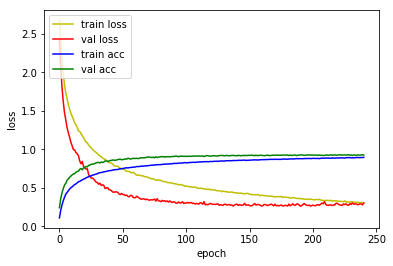

4815/4815 [==============================] - 3s 601us/sample - loss: 0.3387 - acc: 0.9053
Loss: 0.338672388107482 Accuracy: 0.90529597



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_4_ch_64_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_4_ch_64_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 32)          10272     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 3s 602us/sample - loss: 0.2918 - acc: 0.9190
Loss: 0.291794709649289 Accuracy: 0.9190031

1D_CNN_custom_4_ch_64_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None,

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_4_ch_64_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 32)          10272     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 3s 709us/sample - loss: 0.2981 - acc: 0.9215
Loss: 0.2981047599238894 Accuracy: 0.9214953

1D_CNN_custom_4_ch_64_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None